In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import random

In [31]:
tf.random.set_seed(50)

In [32]:
dataset, info = tfds.load('eurosat', with_info=True, as_supervised=True)
full_ds = dataset['train']

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
image_shape = info.features['image'].shape
image_dtype = info.features['image'].tf_dtype

print("===== EuroSAT Dataset Info =====")
print(f"Number of examples: {num_examples}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Image shape: {image_shape}")
print(f"Image dtype: {image_dtype}")

===== EuroSAT Dataset Info =====
Number of examples: 27000
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Image shape: (64, 64, 3)
Image dtype: <dtype: 'uint8'>


In [33]:
# Resize and normalize

def resize_and_rescale(image, label, target=224):
    image = tf.image.resize(image, [target, target])    #resize images from 64×64 to 224×224
    image = tf.cast(image, tf.float32) / 255.0     #convert pixel type
    return image, label

In [34]:
full_ds = full_ds.map(resize_and_rescale)

In [35]:
num_examples = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * num_examples)  
val_size   = int(0.15 * num_examples)  

# 70% train, 15% val, 15% test

train_ds = full_ds.take(train_size)
# Remaining 30%
remaining = full_ds.skip(train_size)

val_ds = remaining.take(val_size)

test_ds = remaining.skip(val_size)

# how many examples in each split
train_count = tf.data.experimental.cardinality(train_ds).numpy()
val_count   = tf.data.experimental.cardinality(val_ds).numpy()
test_count   = tf.data.experimental.cardinality(test_ds).numpy()
print(f"Train examples: {train_count}, Val examples: {val_count}, Test examples: {test_count}")

Train examples: 18900, Val examples: 4050, Test examples: 4050


In [36]:
# Inspect class counts (detect imbalance)
counts = collections.Counter() #dictionary-like object that counts occurrences of items
y_train_list = []


for _, lbl in tfds.as_numpy(train_ds):
    counts[int(lbl)] += 1
    y_train_list.append(int(lbl))

print("Per-class counts (train):")
for cls in sorted(counts.keys()):
    print(f"  class {cls}: {counts[cls]} images")


Per-class counts (train):
  class 0: 2122 images
  class 1: 2143 images
  class 2: 2067 images
  class 3: 1756 images
  class 4: 1756 images
  class 5: 1382 images
  class 6: 1718 images
  class 7: 2095 images
  class 8: 1754 images
  class 9: 2107 images


In [37]:
# no class imbalance, so we'll apply light augmentation just to
# improve model training and generalization and reduce overfitting

#minimal light augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [38]:
#apply augmentation to the training dataset only

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True),y))

In [39]:
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

In [40]:
# Load pretrained model

MobileNet = MobileNetV2 (
    weights = "imagenet",
    include_top = False,        #removes the original ImageNet classification head
    input_shape = (224,224,3)
)

MobileNet.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [41]:
#build the model

MobileNet.trainable = False

# input layer
inputs = Input(shape=(224,224,3))
#pass through mobilenet
MobileNet_features = MobileNet(inputs, training= False)
#pooling layer 
pooled = GlobalAveragePooling2D()(MobileNet_features)
#dropout layer to reduce overfitting (drops neurons)
dropout = Dropout(0.2)(pooled)
#final
predictionLayer = Dense(10, activation='softmax')(dropout)

MobileNetModel = Model(inputs=inputs, outputs=predictionLayer)

MobileNetModel.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [42]:
# Compile model (optimizer updates model's weights to reduce loss)

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
MobileNetModel.compile(optimizer = optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [43]:
# Train model
Batch_size = 64

train_ds = train_ds.batch(Batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(Batch_size).prefetch(tf.data.AUTOTUNE)

history = MobileNetModel.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


296/296 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.7931 - loss: 0.6021 - val_accuracy: 0.8773 - val_loss: 0.3548
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 785s 3s/step - accuracy: 0.8742 - loss: 0.3645 - val_accuracy: 0.8988 - val_loss: 0.2980
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 813s 3s/step - accuracy: 0.8859 - loss: 0.3262 - val_accuracy: 0.9044 - val_loss: 0.2801
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.8943 - loss: 0.3081 - val_accuracy: 0.9086 - val_loss: 0.2682
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - accuracy: 0.8986 - loss: 0.2920 - val_accuracy: 0.9111 - val_loss: 0.2624
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.9013 - loss: 0.2867 - val_accuracy: 0.9119 - val_loss: 0.2573
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.9008 - loss: 0.2837 - val_accuracy: 0.9109 - val_loss: 0.2598
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.9030 - loss: 0.2761 - val_accuracy: 0.910

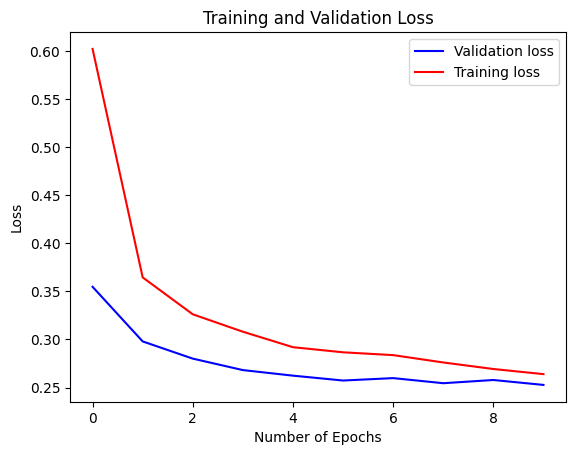

In [44]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_loss'], color='b', label="Validation loss")
plt.plot(history.history['loss'], color='r', label="Training loss")
plt.title("Training and Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

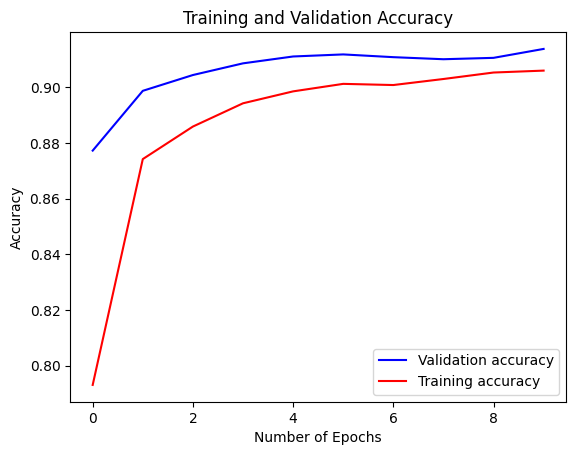

In [45]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_accuracy'], color='b', label="Validation accuracy")
plt.plot(history.history['accuracy'], color='r', label="Training accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [46]:
test_ds = test_ds.batch(Batch_size)
y_prob = MobileNetModel.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)  #to get class index since we're using soft max

y_true = np.concatenate([y for x, y in test_ds], axis=0)   # true labels

64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 917ms/step


In [47]:
# Evaluate model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc= accuracy_score(y_true, y_pred)
prec= precision_score(y_true, y_pred, average='macro')
rec= recall_score(y_true, y_pred, average='macro')
f1= f1_score(y_true, y_pred, average='macro')

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

Accuracy : 0.9182716049382716
Precision: 0.9160950370700396
Recall   : 0.9118710592719786
F1-score : 0.9130378965165893


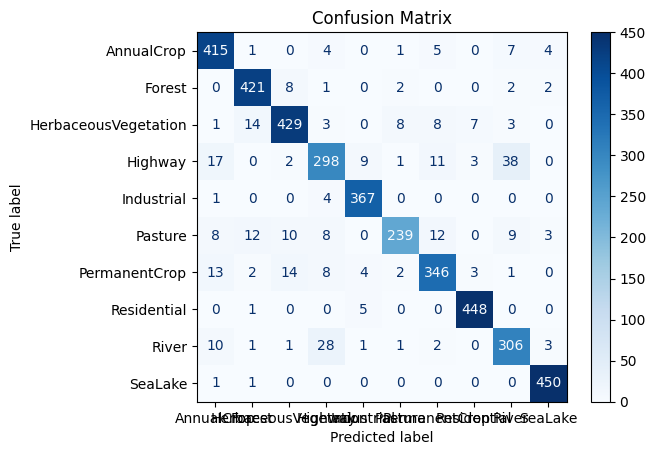

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')  
plt.title("Confusion Matrix")
plt.show()

In [49]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# y_true must be one-hot / binarized
y_true_bin = label_binarize(y_true, classes=range(10))
roc_auc_macro = roc_auc_score(y_true_bin, y_prob, multi_class="ovr", average="macro")
print("Macro-average ROC AUC:", roc_auc_macro)

Macro-average ROC AUC: 0.9955805239593785


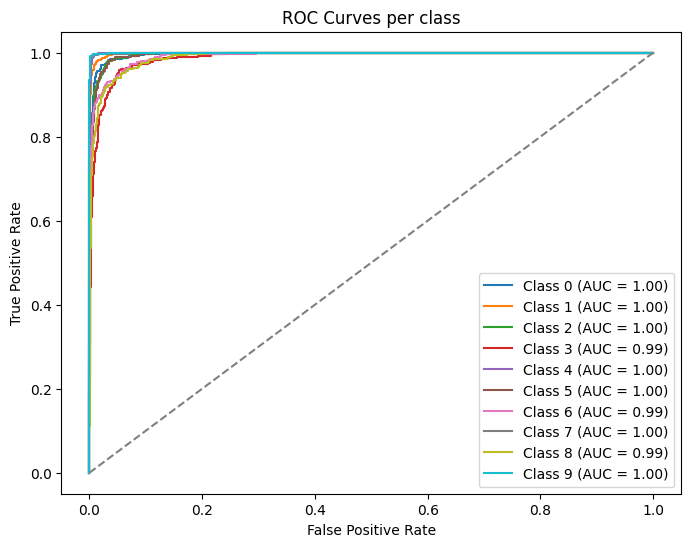

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per class")
plt.legend()
plt.show()